# ANN

The aim of this project is to implement a basic neural network from scratch.

Let's set up the project and look at our data.

## Setup

In [1]:
using Images
using Compose
using Distributions
using Gadfly

In [2]:
include("ann.jl");

In [3]:
df = dataset();

In [4]:
samples = sample(df[df[:y] .== 8, :image], 200);

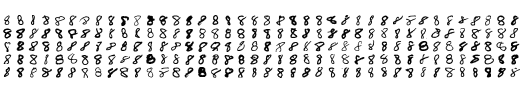

In [5]:
pngs = [to_png(256 - img) for img in samples]
draw(grid(pngs; n_cols = 40)...)

## LinearTransform

Let's try to predict instance. This model simply averages the images in the trainset, grouped by class label.

In [6]:
folds = cv(RandomKFolds, df)
Yp, models = cvpredict(LinearTransform, folds, NoopOpt(), df);

### Evaluation

Let's look at the one vs all evaluation on this training set prediction run:

In [7]:
evaluation(Yp)

,class,accuracy,precision,recall
1,0,0.966,0.764,0.945
2,1,0.975,0.882,0.902
3,2,0.962,0.933,0.666
4,3,0.951,0.753,0.768
5,4,0.96,0.872,0.696
6,5,0.945,0.949,0.418
7,6,0.972,0.829,0.896
8,7,0.97,0.958,0.747
9,8,0.914,0.537,0.869
10,9,0.94,0.656,0.824


In [8]:
describe(evaluation(Yp)[[:precision, :recall]])

precision
Min      0.537
1st Qu.  0.75575
Median   0.8505
Mean     0.8132999999999999
3rd Qu.  0.92025
Max      0.958
NAs      0
NA%      0.0%

recall
Min      0.418
1st Qu.  0.70875
Median   0.796
Mean     0.7730999999999999
3rd Qu.  0.88925
Max      0.945
NAs      0
NA%      0.0%



### Confusion matrix

The most confused digits:

In [9]:
confusions(Yp)[1:10, :]

,y,prediction,x1
1,4,9,1415
2,5,8,1128
3,5,3,1063
4,3,8,951
5,7,9,803
6,2,8,801
7,1,8,670
8,5,0,578
9,2,6,462
10,9,8,448


Overall confusion matrix:

In [10]:
confusion_matrix(Yp; n_classes = 10)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
1,6525,0,11,11,7,2,128,2,206,11
2,0,7106,13,26,3,10,28,4,670,17
3,362,185,4656,241,130,0,462,75,801,78
4,198,59,115,5482,4,59,89,29,951,155
5,72,55,11,4,4750,2,192,6,317,1415
6,578,153,33,1063,104,2637,264,21,1128,332
7,267,95,72,6,40,51,6163,0,181,1
8,231,228,40,21,94,0,12,5451,413,803
9,120,107,18,328,22,16,78,9,5928,199
10,190,69,20,95,292,2,16,92,448,5734


### Confusing instances

The following numbers were misclassified:

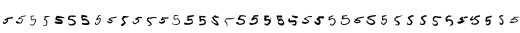

In [11]:
specimen = 5
filtered = Yp[(Yp[:y] .== specimen) & (Yp[:prediction] .!= specimen), :]
draw(grid([to_png(256 - img) for img in sample(filtered[:image], 40)]; n_cols = 40)...)

Let's have a look at the distribution over those misclassifications:

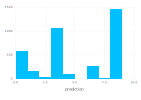

In [12]:
plot(filtered, x = :prediction, Geom.histogram)

The most common confusion is 8, then 3. This is not super surprising; we can see how those might look similar.

### Understanding the model

Let's have a look at the weights of the model. We should be able to visualize the averaged number present in each column. Showing the model learned in the first few folds here:

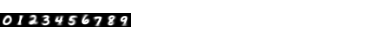

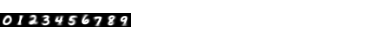

In [13]:
for model in models[1:2]
    masks = model.weights * 2^18.4 # scale up until we see something
    pngs = [to_png(bound(masks[:, i])) for i in 1:10]
    draw(grid(pngs; n_cols = 30)...)
end

So in fact all we're doing is projecting new images against the prototype images we've calculated. Since both vectors have been l2 normalized to unit length, this is equivalent to the cosine distance between those vectors. We pick the one with the smallest angle (eg. the largest projection). 

Another way to view this is that we've stored image masks. Since most of the values in the weights are 0 (black), those pixels will be ignored in the source image, while the white areas will have a value if the input image has ink there. 

## Binary Logistic Regression

This time, let's learn a binary logistic regression model using gradient descent. This model is fully derived using MLE in [the scratch notebook](http://nbviewer.jupyter.org/github/purzelrakete/hi/blob/master/ann/scratch.ipynb#Binary-Logistic-Regression).

In [19]:
df_sampled = sample_df(df, 100)
transforms = transform([ZNormalize, BinarizeLabels], df_sampled)
folds = cv(RandomKFolds, df_sampled, 3)
Yp, models = cvpredict(BinaryLogReg, folds, BatchGradientDescent(0.03, 1), df);

### Evaluation

There's some work left to do to get binary logistic regression working in this multiclass setting, as we can see below.

In [20]:
evaluation(Yp)

,class,accuracy,precision,recall
1,0,0.13,0.13,1.0
2,1,0.86,NaN,0.0
3,2,0.94,NaN,0.0
4,3,0.89,NaN,0.0
5,4,0.89,NaN,0.0
6,5,0.95,NaN,0.0
7,6,0.89,NaN,0.0
8,7,0.9,NaN,0.0
9,8,0.92,NaN,0.0
10,9,0.89,NaN,0.0
